# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Conclusiom](#Conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Some insight into the descriptive statistics of the data.

In [3]:
# Some descriptive statistics about article viewed per email(user)
df[['email','article_id']].groupby(['email']).count().describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [5]:
# Viewed articles per email
df[['email','article_id']].groupby(['email']).count().head(5)

,article_id
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6
001fc95b90da5c3cb12c501d201a915e4f093290,2


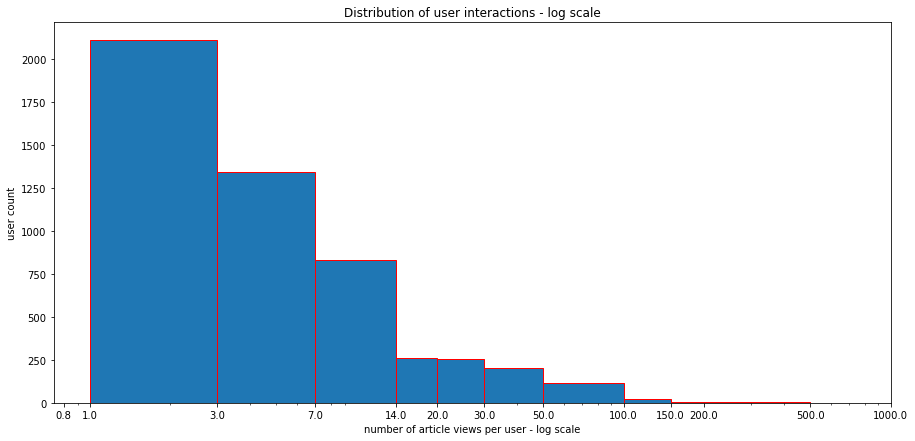

In [20]:
hist_bins = [0,1,3,7,14,20,30,50,100,150,200,500]
hist_ticks = np.array([0.8, 1,3,7,14,20,30,50,100,150,200,500,1000])
plt.figure(figsize=(15,7))
plt.hist(df[['email','article_id']].groupby(['email']).count()['article_id'],bins=hist_bins,histtype='bar',ec='red')
plt.yscale('linear')
plt.xscale('log')
plt.xticks(hist_ticks,hist_ticks.astype(str))
plt.title('Distribution of user interactions - log scale')
plt.xlabel('number of article views per user - log scale')
plt.ylabel('user count')
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [25]:
# Find and explore duplicate articles
is_duplicate = df_content.duplicated(subset=['article_id'])

# Duplicated article_ids
duplicated_articles_id = df_content['article_id'][is_duplicate]
# Corresponding duplicated article names
duplicated_articles_name = df_content['doc_full_name'][is_duplicate]

print('Duplicated article IDs: {}'.format(duplicated_articles_id.values))
print('Duplicated article names: {}'.format(duplicated_articles_name.values))

Duplicated article IDs: []
Duplicated article names: []


In [28]:
# Remove any rows that have the same article_id - only keep the first
print('Number of sample before removing duplicates: {}'.format(df_content.shape[0]))
df_content.drop_duplicates(subset=['article_id'],keep='first',inplace=True)
print('Number of sample after removing duplicates: {}'.format(df_content.shape[0]))

Number of sample before removing duplicates: 1051
Number of sample after removing duplicates: 1051


In [29]:
print('number of unique articles that have at least one interaction: {}'.format(len(df['article_id'].unique())))
print('number of unique articles on the IBM platform: {}'.format(len(df_content['article_id'].unique())))
print('number of unique users: {}'.format(len(df['email'].unique())))
print('number of interactions: {}'.format(df.shape[0]))

number of unique articles that have at least one interaction: 714
number of unique articles on the IBM platform: 1051
number of unique users: 5149
number of interactions: 45993


In [30]:
# The number of unique articles that have at least one interaction
unique_articles = 714

# The number of unique articles on the IBM platform
total_articles = 1051

# The number of unique users
unique_users = 5148

# The number of user-article interactions
user_article_interactions = 45993

In [32]:
# Sort by the most viewed articles
df.groupby(['article_id']).count().sort_values(['title'],ascending=False).head(10)

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


In [33]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


`3.` The **email_mapper** function map users emails to ids.

In [34]:
# The function maps the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show new df
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Since we don't know whether the user likes the article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can be based on how often an article was interacted with.

`1.` The function returns the **n** top articles ordered by the number of interactions.

In [36]:
def get_top_articles(n, df=df):

    # n - the number of top articles to return
    
    df_top_n = df.groupby(['article_id']).count().sort_values(['title'], ascending=False).head(n)
    top_articles_idx = df_top_n.index
        
        
    # A list of the top 'n' article titles
    top_articles = list(df.loc[df['article_id'].isin(top_articles_idx), :]['title'].unique())
    
    return top_articles


def get_top_article_ids(n, df=df):
    
    # n - the number of top articles to return
    
    df_top_n = df.groupby(['article_id']).count().sort_values(['title'],ascending=False).head(n)
    
    # Return the top article ids
    top_articles = list(df_top_n.index)
    
    return top_articles # Return the top article ids

`2.` Testing out the function by listing the **5** and **10** top articles.

In [38]:
# Testing the function

print('TOP 5 ARTICLES (TITLES)')
print(get_top_articles(5))
print('TOP 5 ARTICLES (IDs)')
print(get_top_article_ids(5))

TOP 5 ARTICLES (TITLES)
['use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports']
TOP 5 ARTICLES (IDs)
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]


In [42]:
print('TOP 10 ARTICLES (TITLES)')
print(get_top_articles(10))
print('TOP 10 ARTICLES (IDs)')
print(get_top_article_ids(10))

TOP 10 ARTICLES (TITLES)
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
TOP 10 ARTICLES (IDs)
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [39]:
df_top_n = df.groupby(['article_id']).count().sort_values(['title'],ascending=False).head(10)
df_top_n

,title,user_id
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` **create_user_item_matrix** function reformats the **df** to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* If a user **has** interacted with an article, then place a **1** where the user-row meets for that article-column.


* If a user **has not** interacted with an item, then place a **0** where the user-row meets for that article-column. 


In [43]:
def create_user_item_matrix(df):

    # Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    # an article and a 0 otherwise

    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    # Fill nan with 0
    user_item = user_item.fillna(0)
    
    # Convert every non-zero value into 1
    for col in user_item.columns.values:
        user_item[col] = user_item[col].apply(lambda x: x if x == 0 else 1)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [44]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Save the matrix as pickle file
user_item.to_pickle('user_item_matrix.p')

`2.` **find_similar_users** function takes a user_id and returns an ordered list of the most similar users to that user (from most similar to least similar). 

In [45]:
def find_similar_users(user_id, user_item=user_item):
    # Computes the similarity of every pair of users based on the dot product

    user_sim=np.dot(user_item,user_item.T)
    index=range(1, user_sim.shape[0]+1)
    
    # Fill similarity dataframe
    user_sim=pd.DataFrame(user_sim, index=index, columns=index)
    user_sim=user_sim.loc[user_id,]
    user_sim=user_sim.drop(user_id)
    
    # return a list of the users in order from most to least similar 
    most_similar_users=user_sim.sort_values(ascending=False).index.tolist() 
    
    return most_similar_users

In [46]:
# Test function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` We now have a function that returns the most similar users to each user, now to use these users to find articles to be recommended.

In [47]:
def get_article_names(article_ids, df=df):

    article_names = list(df.loc[df['article_id'].isin(article_ids),'title'].unique())
    
    # Return the article names associated with list of article ids
    return article_names


def get_user_articles(user_id, user_item=user_item):

    # Provides a list of the article_ids and article titles that have been seen by a user

    article_ids = user_item.columns.values[list(user_item.loc[user_id,] == 1)]
    article_ids = article_ids.astype(str)
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names


def user_user_recs(user_id, m=10):


    # Loops through the users based on closeness to the input user_id
    # For each user - finds articles the user hasn't seen before and provides them as recs
    # Does this until m recommendations are found

    most_similar_users = find_similar_users(user_id, user_item=user_item)
    user_article_ids, user_article_names = get_user_articles(user_id)
    recs = list()
    
    for similar_user_id in most_similar_users:
        if len(recs)<m:
            similar_article_ids, similar_article_names = get_user_articles(similar_user_id)
            new_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
            recs.append(new_recs)
            recs = [item for sublist in recs for item in sublist]
        else:
            break
        
    recs = recs[:m]
    
    # return your recommendations for this user_id   
    return recs 

In [48]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

`4.` Some improvement to the **user_user_recs** function from above.  

* When we obtain users who are all the same closeness to a given user, choose the users that have the most total article interactions first.

* Choose articles with the most total interactions first.

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):

    # Initialize dataframe
    neighbors_df=pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    
    # Compute user similarity
    user_sim=np.dot(user_item,user_item.T)
    user_simm=find_similar_users(user_id)
    
    # delete input user from the output
    index=range(1, user_sim.shape[0]+1)
    user_sim=pd.DataFrame(user_sim, index=index, columns=index)
    user_sim=user_sim.loc[user_id]
    user_sim=user_sim.drop(user_id)
    
    # Fill output dataframe
    neighbors_df.neighbor_id=user_sim.index
    neighbors_df.index=user_sim.index
    neighbors_df.similarity=user_sim
    neighbors_df.num_interactions=df.groupby('user_id').count().sort_values('title',ascending=False).drop(user_id)
    
    # Return a dataframe with:
    # neighbor_id, similarity, num_interactions
                    
    return neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False) 


def user_user_recs_part2(user_id, m=10, n_articles=unique_articles):
    
    # Loops through the users based on closeness to the input user_id, finds articles the user hasn't seen before and 
    # provides them as recs until m recommendations are found


    top_articles = get_top_article_ids(n_articles)
    top_sorted_users_df = get_top_sorted_users(user_id, user_item=user_item)
    user_article_ids, user_article_names = get_user_articles(user_id)
    user_article_ids = user_article_ids.astype(np.float)
    recs = np.array([])
    
    for sorted_user_id in top_sorted_users_df['neighbor_id']:
        if len(recs)<m:
            similar_article_ids, similar_article_names = get_user_articles(sorted_user_id)
            
            new_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
            new_recs = np.intersect1d(top_articles,new_recs)
            recs = np.append(recs,new_recs)            
            recs = np.unique(recs)

        else:
            break  
            
    recs = recs[:m]        
    rec_names = get_article_names(recs)
    
    # Return list of article ids and article names
    return recs, rec_names

In [50]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, m=10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


C:\Users\Dietcokeplz\.conda\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [51]:
# Tests with a dictionary of results

# User that is most similar to user 1
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0]

# 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9]

In [53]:
print('User that is most similar to user 1: {}'.format(user1_most_sim))
print('10th most similar user to user 131: {}'.format(user131_10th_sim))

User that is most similar to user 1: 3933
10th most similar user to user 131: 242


`5.` Rank-based Recommendations for the new users.

In [58]:
# Provide a list of the top 10 article ids to new users. 
new_user_recs = get_top_article_ids(10)

print('Top 10 most popular article ids for new users: ', get_top_article_ids(10))

Top 10 most popular article ids for new users:  [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. 

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


In [82]:
df_content_unique = df_content.drop_duplicates().reset_index()

In [83]:
df_content_unique.head()

,index,doc_body,doc_description,doc_full_name,doc_status,article_id
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [100]:
import re
from tqdm import tqdm
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
import string


from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords

# Gensim version of remove punctuation
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

import spacy
import en_core_web_sm

punctuations = string.punctuation
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dietcokeplz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
def sent_to_words(sentence):
    
    return gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations

In [92]:
tqdm.pandas()
data_words = list(df_content_unique["doc_body"].progress_apply(sent_to_words))

100%|█████████████████████████████████████████████████████████████████████████████| 1051/1051 [00:04<00:00, 260.78it/s]


In [93]:
bigram = Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases.
bigram_mod = Phraser(bigram)

In [101]:
# default stop words

stop_words = list(stop_words)

# custom stop words in regard to covid-19

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

# Add custom stop words to the default stop words list
for my_stop_word in custom_stop_words:
    if my_stop_word not in stop_words:
        stop_words.append(my_stop_word)

In [102]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [103]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [104]:
df_content_unique['tokens'] = data_lemmatized

In [105]:
df_content_unique.head()

,index,doc_body,doc_description,doc_full_name,doc_status,article_id,tokens
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,"[skip_navigation, sign, yeah_keep, video, disc..."
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,"[com, com, communicate, data, science, guide, ..."
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,"[login, sign, learn, badges_bdu, watson, welco..."
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,"[high, throughput, scale, boost, performance, ..."
4,4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,"[skip_navigation, sign, yeah_keep, video, disc..."


In [107]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(df_content_unique['tokens'])
dictionary.filter_extremes(no_below=3, no_above=0.3, keep_n=20000)

# Use to preprocess text representations
# doc2bow the returned tuple represents (TOKENid, TOKENcount)
gs_preprocessed_texts = [dictionary.doc2bow(text) for text in df_content_unique['tokens']]

In [120]:
NUM_TOPICS = 7

lda = gensim.models.LdaModel(gs_preprocessed_texts, id2word=dictionary, 
                             num_topics=NUM_TOPICS, random_state=5, alpha=0.1, eval_every=5,
                             gamma_threshold=1e-6)

In [123]:
# store top 3 topics(if applicable) of every paper
Group_1 = []
Group_2 = []
Group_3 = []

# take second element for sort
def takeSecond(elem):
    return elem[1]


for text in gs_preprocessed_texts:
    clusters = lda[text]
    
    clusters.sort(key=takeSecond, reverse = True)
    
    try:
        Group_1.append(lda[text][0][0])
    except:
        Group_1.append(np.nan)
    
    try:
        Group_2.append(lda[text][1][0])
    except:
        Group_2.append(np.nan)
        
    try:
        Group_3.append(lda[text][2][0])
    except:
        Group_3.append(np.nan)

In [124]:
# Create dataframe with paper id, title and top 3 topics for every paper
article_mat = df_content_unique[['article_id', 'doc_full_name']].reset_index().drop(['index'], axis = 1)


article_mat['Group_1'] = Group_1
article_mat['Group_2'] = Group_2
article_mat['Group_3'] = Group_3

In [125]:
article_mat.head(3)

,article_id,doc_full_name,Group_1,Group_2,Group_3
0,0,Detect Malfunctioning IoT Sensors with Streami...,4,6.0,NaN
1,1,Communicating data science: A guide to present...,0,1.0,2.0
2,2,"This Week in Data Science (April 18, 2017)",1,2.0,4.0


In [127]:
article_Group_1 = article_mat[['article_id', 'Group_1']]
article_Group_2 = article_mat[['article_id', 'Group_2']]
article_Group_3 = article_mat[['article_id', 'Group_3']]

article_Group_1 = article_Group_1.rename(columns={"article_id": "article_id", "Group_1": "Group"})
article_Group_2 = article_Group_2.rename(columns={"article_id": "article_id", "Group_2": "Group"})
article_Group_3 = article_Group_3.rename(columns={"article_id": "article_id", "Group_3": "Group"})

article_Group_2 = article_Group_2[article_Group_2['Group'] != 'NaN']
article_Group_3 = article_Group_3[article_Group_3['Group'] != 'NaN']

article_mat = article_Group_1.append(article_Group_2, ignore_index = True)
article_mat = article_mat.append(article_Group_3, ignore_index = True)

# remove duplicated paper_ids with same categories
article_mat.drop_duplicates(inplace = True)

category_mat = article_mat.groupby(['article_id', 'Group'])['Group'].count().unstack()

# If a paper has interacted with a topic, then place a 1 where the paper-row meets for that topic-column
# If a topic does not show as one of the top 3 topics of a paper, then place a 0 where the paper-row meets for that topic-column
category_mat.head(3)

C:\Users\Dietcokeplz\.conda\envs\tensorflow\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Group,0.0,1.0,2.0,3.0,4.0,5.0,6.0
article_id,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
1,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,NaN,1.0,1.0,NaN,1.0,NaN,NaN


In [128]:
category_mat = category_mat.fillna(0)
category_mat.head(3)

Group,0.0,1.0,2.0,3.0,4.0,5.0,6.0
article_id,,,,,,,
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [147]:
def find_topics(lda_model, text):
    
    text = sent_to_words(text)
    
    # Remove Stop Words
    text_nostops = remove_stopwords([text])

    # Form Bigrams
    text_bigram = make_bigrams(text_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp = en_core_web_sm.load(disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    text_lemmatized = lemmatization(text_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    processed_text = dictionary.doc2bow(text_lemmatized[0])
    
    result = lda_model[processed_text]
    
    result.sort(key=takeSecond, reverse = True)
    
    # Create matrix of 15 zeros to store probability
    result_mat = np.zeros(7)
    count = 0
    
    for topic in result:
        
        result_mat[topic[0]] = topic[1]
        count += 1
        
        if count >= 3:
            break
    
    return [result, result_mat]


# Calculate similarity between the unseed text and every paper else using matrix factorization

def find_similarities(category_mat, topics):
    
    rows = category_mat.shape[0]
    
    paper_ids = []
    similarities = []
    
    for n in range(0, rows):
        
        paper_id = category_mat.iloc[n].name
        
        similarity = np.dot(category_mat.iloc[n].values, topics.T)
        
        paper_ids.append(paper_id)
        similarities.append(similarity)
        
    return paper_ids, similarities

In [150]:
# Top 10 similar papers
top_10 = similarity_mat.head(10)
top_10

,article_ids,similarity
0,0,0.995853
531,531,0.995853
479,479,0.995853
455,455,0.995853
443,443,0.995853
437,437,0.995853
429,429,0.995853
391,391,0.995853
377,377,0.995853
366,366,0.995853


In [165]:
# article_id is an int
# n_recs is an int
def make_recs(article_id, lda_model, n_recs):
    
    sample_text = df_content_unique.loc[article_id]['doc_body']
    
    article_ids, similarities = find_similarities(category_mat, find_topics(lda_model, sample_text)[1])
    # Create the dataframe and sort by similarity
    similarity_mat = pd.DataFrame({'article_ids': article_ids, 'similarity': similarities}).sort_values(by = ['similarity'], ascending = False)
    
    # delete the sample text itself
    similarity_mat = similarity_mat[similarity_mat['article_ids'] != article_id]
    
    # Top 10 similar papers
    top_n = similarity_mat.head(n_recs)['article_ids']
    top_n_mat = df_content_unique[df_content_unique['article_id'].apply(lambda x: x in top_n)][['article_id', 'doc_full_name']]
    return top_n_mat

In [167]:
# Top 10 recommendations for article id 0 based on content
make_recs(0, lda, 10)

,article_id,doc_full_name
355,355,Run Shiny Applications in RStudio in DSX
366,366,Clustering: A Guide for the Perplexed
377,377,Transporter 0.3.0 Released - Transporter Strea...
391,391,Building better database bridges with the new ...
429,429,Why Relational Databases and R?
437,437,IBM Watson Machine Learning: Get Started
443,443,Load Db2 Warehouse on Cloud data with Apache S...
455,455,Make machine learning a reality for your enter...
479,479,Drowning in data sources: How data cataloging ...
531,531,OSCON Europe Talk Review


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

Matrix factorization will be used to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Load the pickle files of **user_item_matrix**. 

In [60]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [61]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Use Singular Value Decomposition on the user-item matrix.

In [63]:
# Perform SVD on the User-Item Matrix.
u, s, vt = np.linalg.svd(user_item_matrix)

`3.` Decide number of latent features to use.

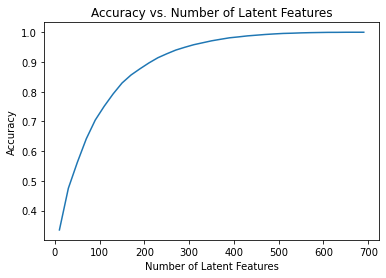

In [64]:
num_latent_features = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_features:
    # loop with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # compute dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error ratio for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # keep track of the errors
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# Plot the accuracy vs number of latent features curve    
plt.plot(num_latent_features, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` We might not be sure how many features to use given the graph, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. We might split our dataset into a training and test set of data instead.  

In [65]:
# Split the dataset into train and test sets.
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    
    # test_idx - all of the test user ids
    # test_arts - all of the test article ids    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [67]:
user_item_train

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4484,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
print('articles of the test set we can make predictions about')
print(len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('articles of the test set we cannot make predictions about')
print(len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('users of the test set we can make predictions about')
print(len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

print('users of the test set we cannot make predictions about')
print(len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

articles of the test set we can make predictions about
574
articles of the test set we cannot make predictions about
0
users of the test set we can make predictions about
20
users of the test set we cannot make predictions about
662


All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on. Therefore, we cannot make predictions for these users using SVD. For those users that are not in train dataset, we might see them as new users and will make recommendations using rank-based recommendations.

`5.` Let's see how prediction on the 'predictable' users in test dataset performs. Now apply SVD on the user_item_train dataset. Then find the subset of rows in the user_item_test dataset that can be predicted using SVD with different numbers of latent features.

In [72]:
# Find train articles and user ids
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Find users and articles of the test set contained also in the training set
test_user_subset = np.intersect1d(test_idx,train_idx)
test_articles_subset = np.intersect1d(test_arts,train_arts)

# Find the position in the training matrix of the test subset
train_indexes = np.where(np.in1d(train_idx, test_user_subset))[0]
train_articles = np.where(np.in1d(train_arts, test_articles_subset))[0]

# Find the position in the test matrix of the test subset
test_indexes = np.where(np.in1d(test_idx, test_user_subset))[0]

### MODEL TRAINING

In [73]:
# perform SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [74]:
# Find the users and articles that are shared by train and test set

user_item_test_subset = user_item_test.iloc[test_indexes,:]
user_item_train_subset = user_item_train.iloc[train_indexes,train_articles]

### MODEL TESTING

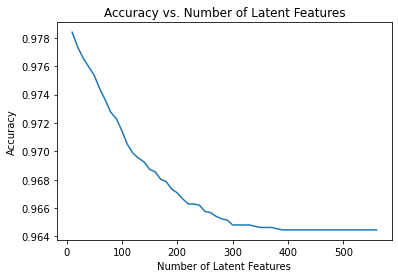

In [76]:
num_latent_features = np.arange(10,570,10)
sum_errs = []

for k in num_latent_features:
    # loop with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # compute dot product
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error ratio for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_subset_est)
    
    # keep track of the errors
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


n_interactions_subset = user_item_test_subset.shape[0]*user_item_test_subset.shape[1]

# Plot the accuracy vs number of latent features curve 
plt.plot(num_latent_features, 1 - np.array(sum_errs)/n_interactions_subset);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### <a class="anchor" id="Conclusions">Part VI: Conclusion</a>

The results might not be statistically significant, since just a few users (20) are shared among trains and test set. Moreover, 1's and 0's represent an highly imbalanced problem and this fact explains the very high accuracy value.

**NEXT STEPS**

Once reccomendation engine is built, there are two main steps to assess its performance

1. Make an ensemble of reccomendation engine algorithms (SVD, Collaborative Filtering, Content Based, Ranking based...) to cover all the possible situation (new user to reccomend, new articles to be reccomended).
2. Design an Experiment to understand the performance of the recommendation engine.

**About A/B Tesing**

**A/B Test** approach is a solid procedure to understand if the model brings real benefits. 
* **Cookie-based** <br/>A/B splitting  allows to randomly assign a user to one of the two groups: one group uses the old homepage featuring suggestions for articles from the "old" reccomendation engine while the second group interacts with the same homepage featuring suggestions from the new reccomendation engine.
* **Funnel** <br/>Expect a user entering the homepage following steps: <br/>**1)** visit the homepage <br/>**2)** browse the homepage looking for suggested articles <br/>**3)** click on a particular article.
* **Invariant Metric** <br/>Assume the assignment of users to the two homepages is random, we expect the number of cookies hitting the two homepages not to be significally different so that a statistical test can be performed.
* **Evaluation Metric** <br/>A possible choice could be the #clicks-on-reccomendations / #cookies. If new reccomendation system is actually better than the previous one, the average number of clicks on reccomendation per user in the experiment group must be greater than the control group value.
* **Experiment Sizing** <br/>An appropriate significant level that guarantees a Type I error lower than 0.05. We need to guarantee a certain amount of visits per day to understand how long the experiment last to meet statistical constraints.


In [168]:
viz_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010960  0.012979       1        1  19.109406
5     -0.000975  0.000997       2        1  18.399172
4     -0.017071  0.006790       3        1  15.425880
0      0.011151 -0.011281       4        1  14.782341
2      0.006838  0.004322       5        1  13.972018
6     -0.001324 -0.007435       6        1  10.256537
3     -0.009578 -0.006372       7        1   8.054648, topic_info=          Term         Freq        Total Category  logprob  loglift
1315    dashdb   682.000000   682.000000  Default  30.0000  30.0000
1295  cloudant  2022.000000  2022.000000  Default  29.0000  29.0000
72       video   896.000000   896.000000  Default  28.0000  28.0000
16    duration   335.000000   335.000000  Default  27.0000  27.0000
807      index  1269.000000  1269.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
930        app    70.888908  1026.235962   Topic7  -5.9740  -0.1536
720     server    64.341797   864.024353   Topic7  -6.0709  -0.0785
1436  variable    62.320103   752.387878   Topic7  -6.1028   0.0280
875       year    60.255291   682.596008   Topic7  -6.1365   0.0916
558      table    64.453285  1310.769653   Topic7  -6.0692  -0.4935

[600 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6094      1  0.477902  accordance
6094      2  0.238951  accordance
6094      5  0.238951  accordance
878       1  0.215636     account
878       2  0.148250     account
...     ...       ...         ...
4751      3  0.106644        ylab
4751      4  0.213287        ylab
4751      5  0.106644        ylab
4751      6  0.106644        ylab
4751      7  0.106644        ylab

[2587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 1, 3, 7, 4])